In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('D:\Excel files/salesdatasample.csv', encoding='latin1')

In [3]:
# Convert ORDERDATE to datetime format
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'], errors='coerce')

In [4]:
# Drop rows with invalid or missing ORDERDATE
df = df.dropna(subset=['ORDERDATE'])

In [5]:
# Sort the dataset by date
df = df.sort_values('ORDERDATE')

In [6]:
# Create a new column 'Month' for monthly aggregation
df['Month'] = df['ORDERDATE'].dt.to_period('M')

In [7]:
# Group sales data by month
monthly_sales = df.groupby('Month')['SALES'].sum().reset_index()

In [8]:
# Convert 'Month' from Period to Timestamp for plotting/forecasting
monthly_sales['Month'] = monthly_sales['Month'].dt.to_timestamp()

In [9]:
# Preview the preprocessed data
print("Sample of original data:")
print(df.head())

print("\nMonthly sales summary:")
print(monthly_sales.head())

Sample of original data:
      ORDERNUMBER  QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  \
578         10100               30     100.00                3  5151.00   
680         10100               50      67.80                2  3390.00   
1267        10100               22      86.51                4  1903.22   
2024        10100               49      34.47                1  1689.03   
1539        10101               45      31.20                3  1404.00   

      ORDERDATE   STATUS  QTR_ID  MONTH_ID  YEAR_ID  ... ADDRESSLINE2  \
578  2003-01-06  Shipped       1         1     2003  ...          NaN   
680  2003-01-06  Shipped       1         1     2003  ...          NaN   
1267 2003-01-06  Shipped       1         1     2003  ...          NaN   
2024 2003-01-06  Shipped       1         1     2003  ...          NaN   
1539 2003-01-09  Shipped       1         1     2003  ...          NaN   

           CITY STATE POSTALCODE  COUNTRY TERRITORY CONTACTLASTNAME  \
578      Nashu

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

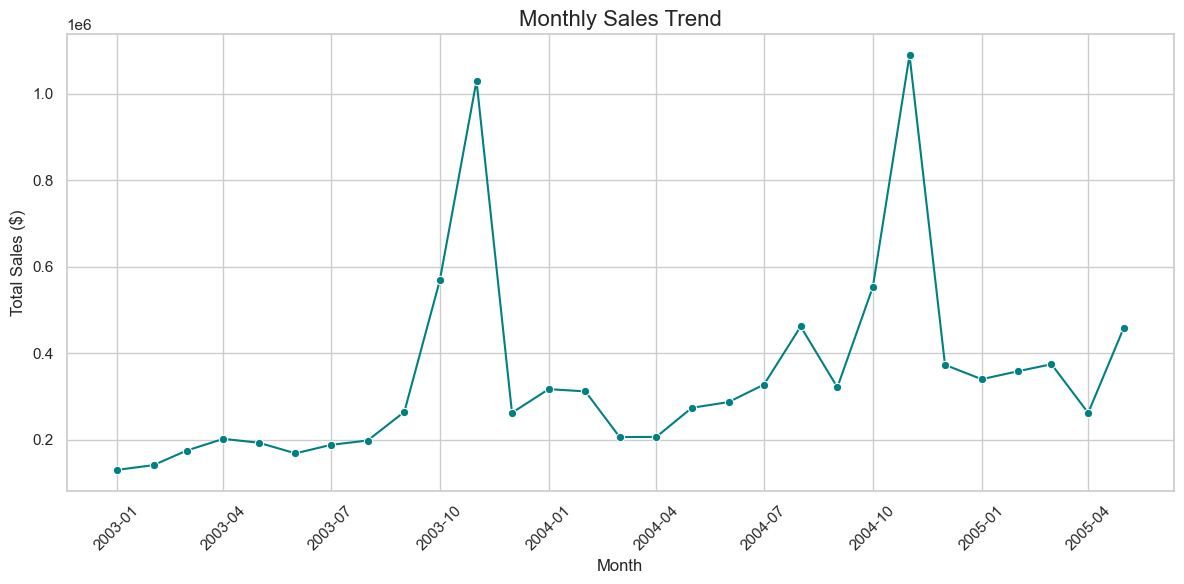

In [11]:
# Set the visual style
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales, x='Month', y='SALES', marker='o', color='teal')

# Add titles and labels
plt.title("Monthly Sales Trend", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Total Sales ($)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


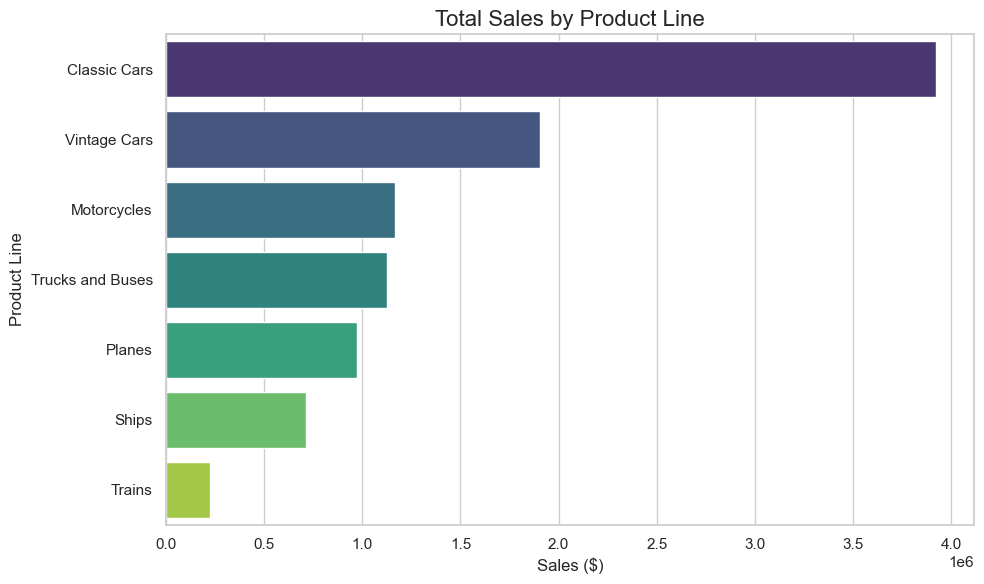

In [12]:
plt.figure(figsize=(10, 6))
product_sales = df.groupby('PRODUCTLINE')['SALES'].sum().sort_values(ascending=False)
sns.barplot(x=product_sales.values, y=product_sales.index, palette="viridis")

plt.title("Total Sales by Product Line", fontsize=16)
plt.xlabel("Sales ($)", fontsize=12)
plt.ylabel("Product Line", fontsize=12)
plt.tight_layout()
plt.show()


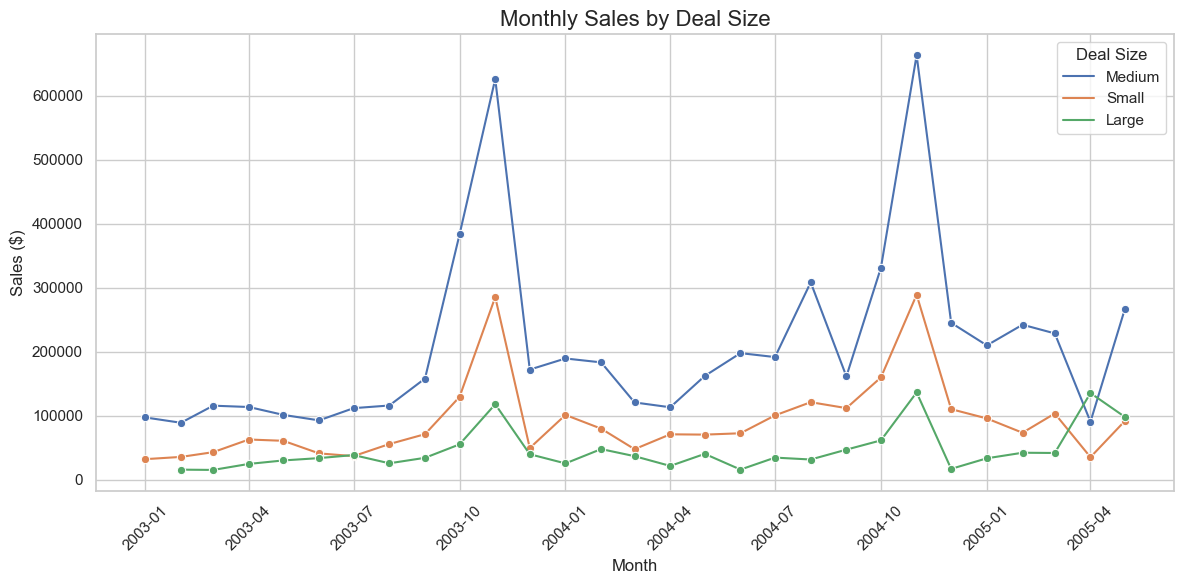

In [13]:
# Group by Month and Deal Size
deal_monthly = df.groupby(['Month', 'DEALSIZE'])['SALES'].sum().reset_index()
deal_monthly['Month'] = deal_monthly['Month'].dt.to_timestamp()

plt.figure(figsize=(12, 6))
sns.lineplot(data=deal_monthly, x='Month', y='SALES', hue='DEALSIZE', marker='o')

plt.title("Monthly Sales by Deal Size", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Sales ($)", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Deal Size")
plt.tight_layout()
plt.show()


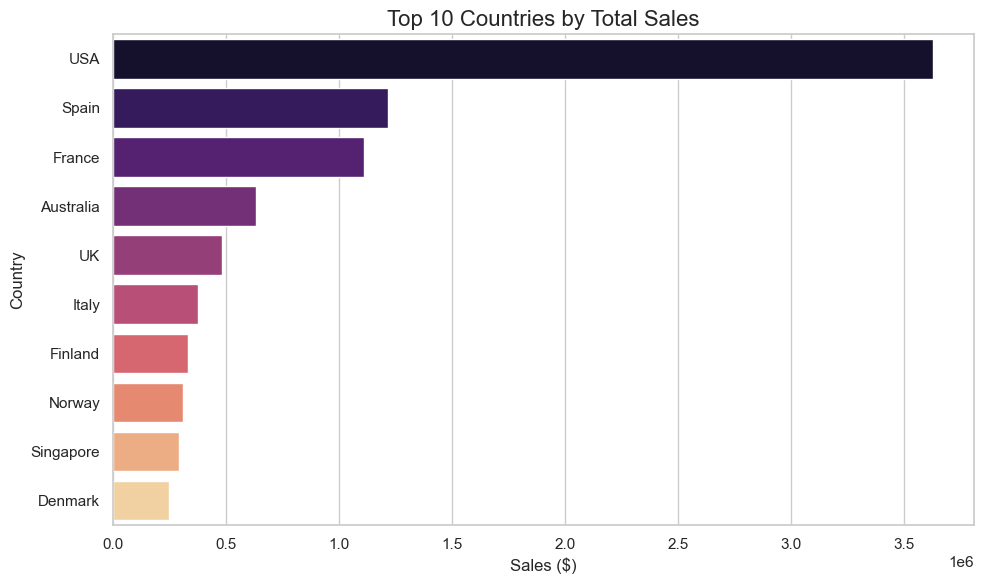

In [14]:
plt.figure(figsize=(10, 6))
top_countries = df.groupby('COUNTRY')['SALES'].sum().sort_values(ascending=False).head(10)
sns.barplot(x=top_countries.values, y=top_countries.index, palette='magma')

plt.title("Top 10 Countries by Total Sales", fontsize=16)
plt.xlabel("Sales ($)", fontsize=12)
plt.ylabel("Country", fontsize=12)
plt.tight_layout()
plt.show()


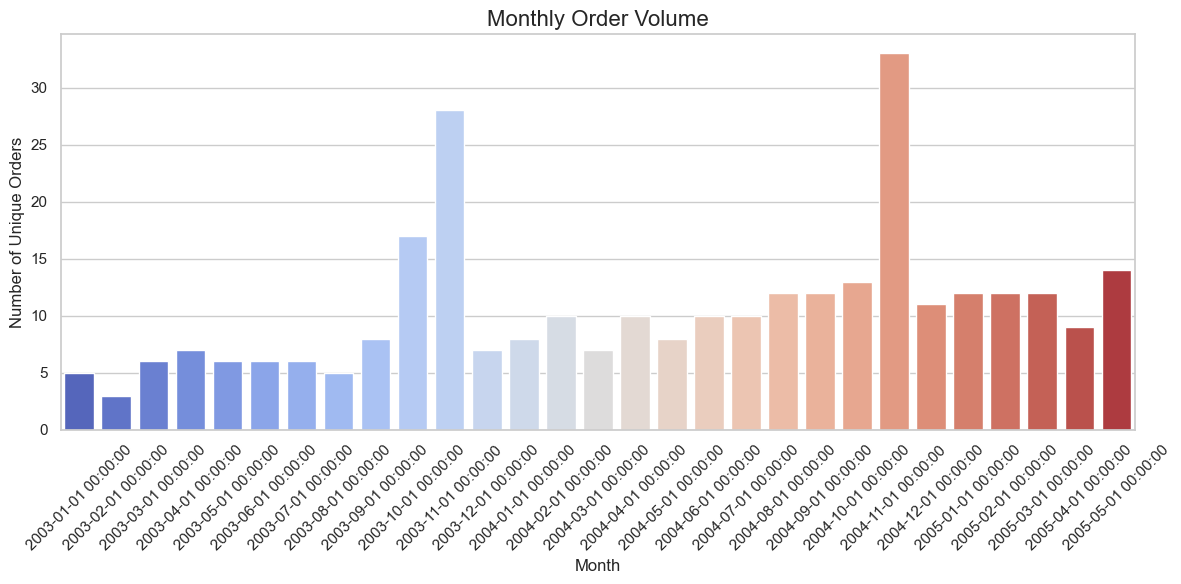

In [15]:
order_volume = df.groupby('Month')['ORDERNUMBER'].nunique().reset_index()
order_volume['Month'] = order_volume['Month'].dt.to_timestamp()

plt.figure(figsize=(12, 6))
sns.barplot(data=order_volume, x='Month', y='ORDERNUMBER', palette='coolwarm')

plt.title("Monthly Order Volume", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Number of Unique Orders", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [16]:
#pip install prophet

00:41:18 - cmdstanpy - INFO - Chain [1] start processing
00:41:19 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\ASUS\AppData\Local\Temp\ipykernel_4216\2909672186.py:22: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


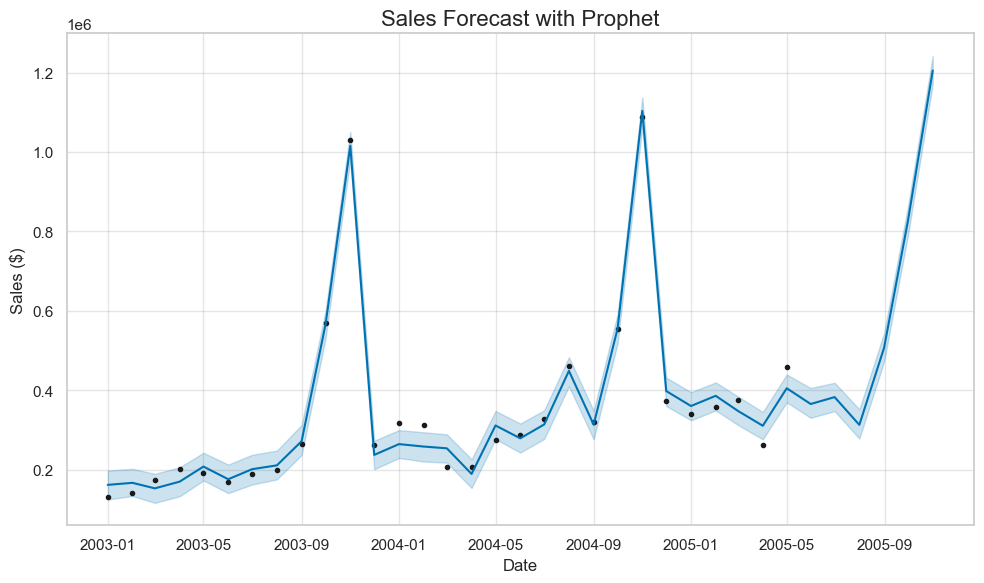

C:\Users\ASUS\AppData\Local\Temp\ipykernel_4216\2909672186.py:27: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


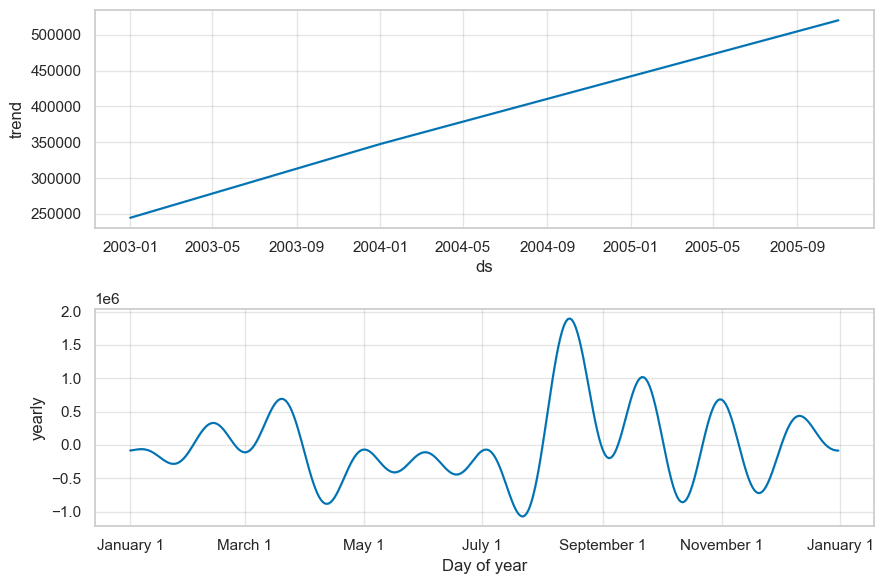

In [17]:
from prophet import Prophet
import matplotlib.pyplot as plt

# Step 1: Prepare the data for Prophet
df_prophet = monthly_sales.rename(columns={'Month': 'ds', 'SALES': 'y'})

# Step 2: Initialize and train the model
model = Prophet()
model.fit(df_prophet)

# Step 3: Create future dates (e.g., forecast next 6 months)
future = model.make_future_dataframe(periods=6, freq='M')

# Step 4: Generate the forecast
forecast = model.predict(future)

# Step 5: Plot the forecast
model.plot(forecast)
plt.title("Sales Forecast with Prophet", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Sales ($)")
plt.tight_layout()
plt.show()

# Optional: Plot forecast components (trend, seasonality)
model.plot_components(forecast)
plt.tight_layout()
plt.show()


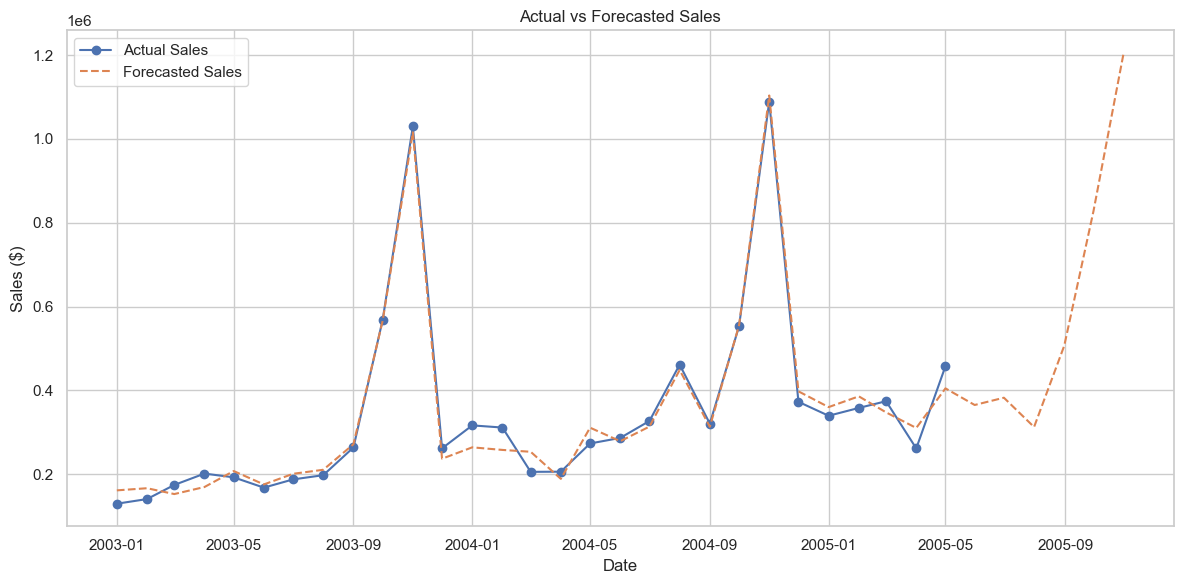

In [18]:
import matplotlib.pyplot as plt

# Merge actual and forecasted values
merged = forecast[['ds', 'yhat']].merge(df_prophet, on='ds', how='left')

plt.figure(figsize=(12, 6))
plt.plot(merged['ds'], merged['y'], label='Actual Sales', marker='o')
plt.plot(merged['ds'], merged['yhat'], label='Forecasted Sales', linestyle='--')
plt.title("Actual vs Forecasted Sales")
plt.xlabel("Date")
plt.ylabel("Sales ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


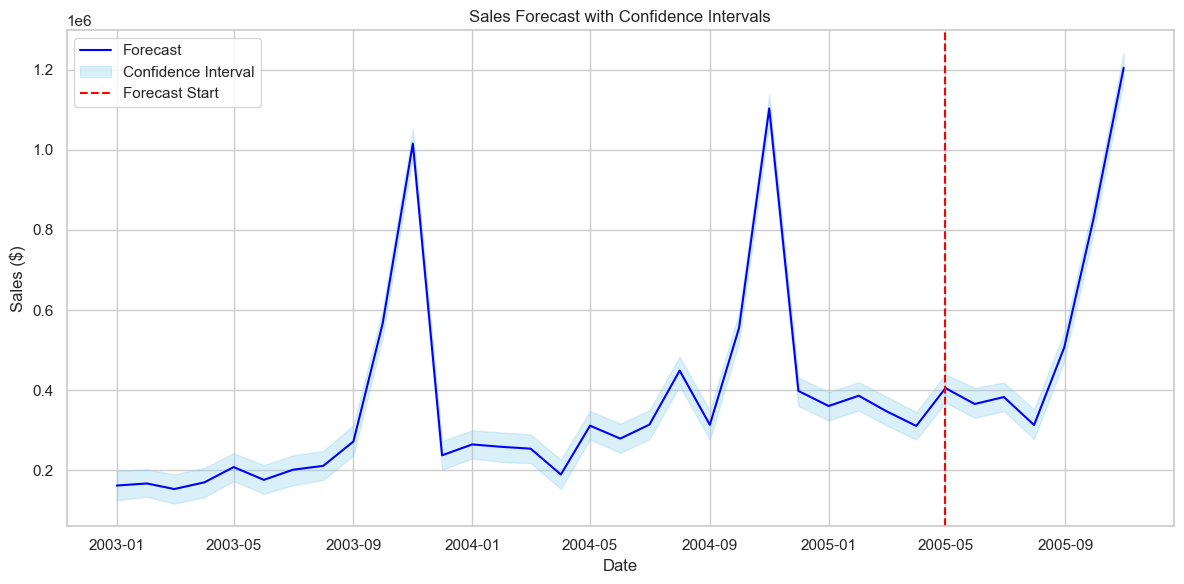

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='blue')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], 
                 color='skyblue', alpha=0.3, label='Confidence Interval')
plt.axvline(df_prophet['ds'].max(), color='red', linestyle='--', label='Forecast Start')
plt.title("Sales Forecast with Confidence Intervals")
plt.xlabel("Date")
plt.ylabel("Sales ($)")
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\ASUS\AppData\Local\Temp\ipykernel_4216\895424586.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  residuals['error'] = residuals['y'] - residuals['yhat']


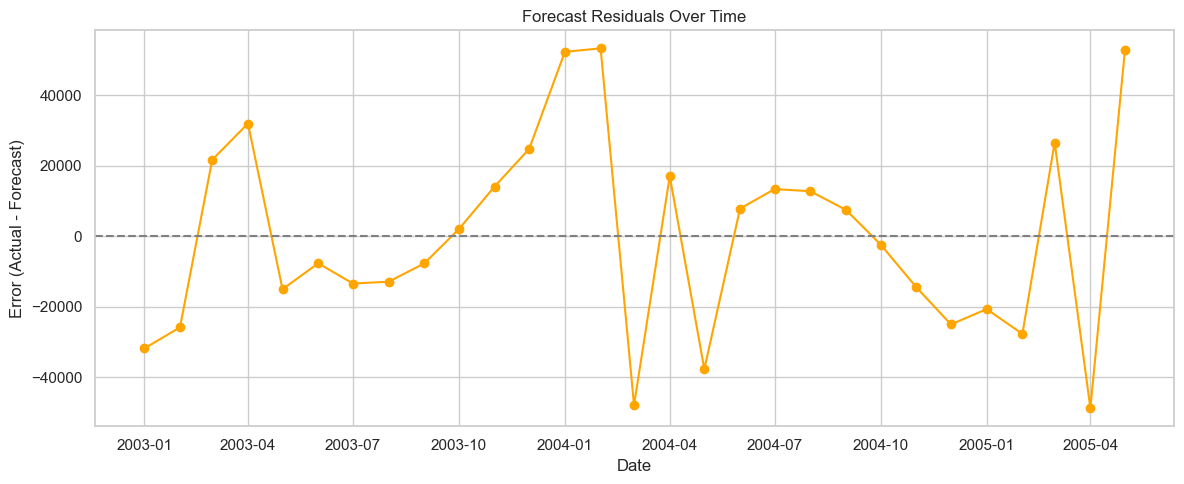

In [20]:
# Compute residuals only where actuals exist
residuals = merged.dropna()
residuals['error'] = residuals['y'] - residuals['yhat']

plt.figure(figsize=(12, 5))
plt.plot(residuals['ds'], residuals['error'], marker='o', linestyle='-', color='orange')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Forecast Residuals Over Time")
plt.xlabel("Date")
plt.ylabel("Error (Actual - Forecast)")
plt.tight_layout()
plt.show()


In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Merge forecast and actual sales
merged = forecast[['ds', 'yhat']].merge(df_prophet, on='ds', how='left')
merged = merged.dropna()

# Extract actual and predicted values
actual = merged['y']
predicted = merged['yhat']

# Evaluation Metrics
mae = mean_absolute_error(actual, predicted)
rmse = np.sqrt(mean_squared_error(actual, predicted))
mape = np.mean(np.abs((actual - predicted) / actual)) * 100

# Display results
print(f"📊 Model Evaluation:")
print(f"MAE  (Mean Absolute Error):      {mae:.2f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")
print(f"MAPE (Mean Absolute % Error):   {mape:.2f}%")


📊 Model Evaluation:
MAE  (Mean Absolute Error):      23366.01
RMSE (Root Mean Squared Error): 27964.19
MAPE (Mean Absolute % Error):   9.03%


In [25]:
from sklearn.metrics import r2_score

# Actual and predicted values
actual = merged['y']
predicted = merged['yhat']

# R² Score
r2 = r2_score(actual, predicted)

print(f"R² Score (Accuracy): {r2:.4f}")


R² Score (Accuracy): 0.9844
